In [258]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os 
import matplotlib.ticker as ticker
from main import evaluate
from opponent import make_opponent
from gymnasium import spaces
from TD3_agent import TD3_Agent
import hockey.hockey_env as hockey_env


# Win rates after training
Find the most promising candidate to continue training upon

In [259]:
# load all available final agents
JOB_IDs = {"Opponent: strong, Iter=1, Gaussian/Orn": "1985807", 
           "Opponent: strong, Iter=8/4, Gauss/Orn": "1985808",
           "Opponent: strong, Iter=1, Pink": "1986229",
           "Opponent: strong, Iter=1, Pink, Prioritized ER": "1986341",
           "Opponent: strong, Iter=1, Gaussian, Prioritized ER": "1986633",
           "Opponent: pretrained self, Iter=1, Pink, Prioritized ER": "1986931",
           "Opponent: current self, Iter=1, Pink": "1986278",
           "Opponent: current self, Iter=1, Ornstein": "1986284",
           "Opponent: weak, Iter=1, Ornstein-Uhlenbeck, normal buffer": "1986415",
           "Opponent: weak, Iter=1, Ornstein-Uhlenbeck": "1986036", # slightly lower win rate in eval
           "Opponent: weak, Iter=1, Gaussian": "1985908", # can also have 99.5% seldomly
           "Opponent: weak, Iter=1, Pink": "1986002", # slightly lower win rate (99.5%)
           "Opponent: weak, Iter=1, Ornstein, Prioritized ER": "1986413",
           } 
paths_map = {name: f"./{job_id}/saved/td3_final.pt" for name, job_id in JOB_IDs.items()}


In [260]:
# ── EVALUATION HELPER ─────────────────────────────
def evaluate_matchup(agent_path, opponent_path, n_games=200):
    """
    Play agent (from agent_path) vs opponent (from opponent_path).
    Returns (wins, losses, ties) from agent's perspective.
    If opponent_path is 'weak' or 'strong', uses BasicOpponent.
    """
    env = hockey_env.HockeyEnv()
    obs_dim = env.observation_space.shape[0]
    full_action_space = env.action_space
    n_per_player = full_action_space.shape[0] // 2
    action_space = spaces.Box(
        low=full_action_space.low[:n_per_player],
        high=full_action_space.high[:n_per_player],
        dtype=full_action_space.dtype
    )

    # load agent
    agent = TD3_Agent(
        obs_dim=obs_dim, act_dim=n_per_player,
        observation_space=env.observation_space,
        action_space=action_space, device='cpu'
    )
    agent.load(agent_path)

    # load opponent
    if opponent_path == 'weak':
        opponent = hockey_env.BasicOpponent(weak=True)
        opp_type = 'weak'
    elif opponent_path == 'strong':
        opponent = hockey_env.BasicOpponent(weak=False)
        opp_type = 'strong'
    else:
        opponent = TD3_Agent(
            obs_dim=obs_dim, act_dim=n_per_player,
            observation_space=env.observation_space,
            action_space=action_space, device='cpu'
        )
        opponent.load(opponent_path)
        opp_type = 'pretrained_self'

    wins, losses, ties = 0, 0, 0
    for _ in range(n_games):
        s1, _ = env.reset()
        s2 = env.obs_agent_two()
        ended = False
        while not ended:
            a1 = agent.select_action(s1, explore=False)
            if isinstance(opponent, hockey_env.BasicOpponent):
                a2 = opponent.act(s2)
            else:
                a2 = opponent.select_action(s2, explore=False)
            s1, _, terminated, truncated, info = env.step(np.hstack([a1, a2]))
            s2 = env.obs_agent_two()
            ended = terminated or truncated

        w = info.get('winner', 0)
        if w == 1:    wins += 1
        elif w == -1: losses += 1
        else:         ties += 1

    env.close()
    return wins, losses, ties

In [262]:
# ── RUN ALL MATCHUPS ──────────────────────────────
agent_names = list(paths_map.keys())
N_GAMES = 200
# include weak and strong as "opponents" for the columns
all_opponents = ['weak', 'strong'] + agent_names

# results[row_agent][col_opponent] = (wins, losses, ties)
results = {}

for name1 in agent_names:
    results[name1] = {}
    path1 = paths_map[name1]
    
    # vs weak
    print(f'{name1} vs weak ...', end=' ')
    w, l, t = evaluate_matchup(path1, 'weak', N_GAMES)
    results[name1]['weak'] = (w, l, t)
    print(f'W={w} L={l} T={t}')
    
    # vs strong
    print(f'{name1} vs strong ...', end=' ')
    w, l, t = evaluate_matchup(path1, 'strong', N_GAMES)
    results[name1]['strong'] = (w, l, t)
    print(f'W={w} L={l} T={t}')
    
    # vs other agents
    for name2 in agent_names:
        if name1 == name2:
            results[name1][name2] = None  # skip self
            continue
        print(f'{name1} vs {name2} ...', end=' ')
        path2 = paths_map[name2]
        w, l, t = evaluate_matchup(path1, path2, N_GAMES)
        results[name1][name2] = (w, l, t)
        print(f'W={w} L={l} T={t}')

print('\nAll matchups complete.')

Opponent: strong, Iter=1, Gaussian/Orn vs weak ... Loaded saved from ./1985807/saved/td3_final.pt
W=190 L=3 T=7
Opponent: strong, Iter=1, Gaussian/Orn vs strong ... Loaded saved from ./1985807/saved/td3_final.pt
W=200 L=0 T=0
Opponent: strong, Iter=1, Gaussian/Orn vs Opponent: strong, Iter=8/4, Gauss/Orn ... Loaded saved from ./1985807/saved/td3_final.pt
Loaded saved from ./1985808/saved/td3_final.pt
W=101 L=95 T=4
Opponent: strong, Iter=1, Gaussian/Orn vs Opponent: strong, Iter=1, Pink ... Loaded saved from ./1985807/saved/td3_final.pt
Loaded saved from ./1986229/saved/td3_final.pt
W=101 L=65 T=34
Opponent: strong, Iter=1, Gaussian/Orn vs Opponent: strong, Iter=1, Pink, Prioritized ER ... Loaded saved from ./1985807/saved/td3_final.pt
Loaded saved from ./1986341/saved/td3_final.pt
W=169 L=26 T=5
Opponent: strong, Iter=1, Gaussian/Orn vs Opponent: strong, Iter=1, Gaussian, Prioritized ER ... Loaded saved from ./1985807/saved/td3_final.pt
Loaded saved from ./1986633/saved/td3_final.pt
W

In [ ]:
# rename
# load all available final agents
JOB_IDs = {"Opponent: strong, Iter=1, Gaussian/Orn": "1985807", 
           "Opponent: strong, Iter=8/4, Gauss/Orn": "1985808",
           "Opponent: strong, Iter=1, Pink": "1986229",
           "Opponent: strong, Iter=1, Pink, Prioritized ER": "1986341",
           "Opponent: strong, Iter=1, Gaussian, Prioritized ER": "1986633",
           "Opponent: pretrained self, Iter=1, Pink, Prioritized ER": "1986931",
           "Opponent: current self, Iter=1, Pink": "1986278",
           "Opponent: current self, Iter=1, Ornstein": "1986284",
           "Opponent: weak, Iter=1, Ornstein-Uhlenbeck, normal buffer": "1986415",
           "Opponent: weak, Iter=1, Ornstein-Uhlenbeck": "1986036", # slightly lower win rate in eval
           "Opponent: weak, Iter=1, Gaussian": "1985908", # can also have 99.5% seldomly
           "Opponent: weak, Iter=1, Pink": "1986002", # slightly lower win rate (99.5%)
           "Opponent: weak, Iter=1, Ornstein, Prioritized ER": "1986413",
           } 
paths_map = {name: f"./{job_id}/saved/td3_final.pt" for name, job_id in JOB_IDs.items()}


In [288]:
# rename
map_names = {"Opponent: strong, Gaussian/Orn":                           "strong,     G/OU", 
            "Opponent: strong, Iter=8/4, Gauss/Orn":                     "strong,     G, Iter=8/4",
            "Opponent: strong, Iter=1, Pink":                            "strong,     P",
            "Opponent: strong, Iter=1, Pink, Prioritized ER":            "strong,     P, PER",
            "Opponent: strong, Iter=1, Gaussian, Prioritized ER":        "strong,     G, PER",
            "Opponent: pretrained self, Iter=1, Pink, Prioritized ER":   "pretrained, P, PER",
            "Opponent: current self, Iter=1, Pink":                      "current,    P",
            "Opponent: current self, Iter=1, Ornstein":                  "current,    OU",
            "Opponent: weak, Iter=1, Ornstein-Uhlenbeck, normal buffer": "weak1,      OU",
            "Opponent: weak, Iter=1, Ornstein-Uhlenbeck":                "weak2,      OU", # slightly lower win rate in eval
            "Opponent: weak, Iter=1, Gaussian":                          "weak,       G", # can also have 99.5% seldomly
            "Opponent: weak, Iter=1, Pink":                              "weak,       P", # slightly lower win rate (99.5%)
            "Opponent: weak, Iter=1, Ornstein, Prioritized ER":          "weak,       OU, PER",
            } 

# map the names in results
results2 = {map_names.get(k,k): {map_names.get(k2,k2): v2 for k2, v2 in v.items()}
            for k, v in results.items()}

# reorder: group by training opponent, then by noise type
agent_order = [
    # trained vs weak
    "weak,       G",
    "weak1,      OU",
    "weak2,      OU",
    "weak,       OU, PER",
    "weak,       P",
    # trained vs strong
    "strong,     G/OU",
    "strong,     G, Iter=8/4",
    "strong,     G, PER",
    "strong,     P",
    "strong,     P, PER",
    # trained vs self
    "current,    P",
    "current,    OU",
    "pretrained, P, PER",
]

# filter to only agents that exist in results
agent_names = [n for n in agent_order if n in results2]
all_opponents = ["weak", "strong"] + agent_names


In [289]:
# ── BUILD WIN RATE MATRIX ─────────────────────────
win_rate_matrix = pd.DataFrame(
    index=agent_names, columns=all_opponents, dtype=float
)

for name1 in agent_names:
    for opp in all_opponents:
        r = results2[name1].get(opp)
        if r is None:
            win_rate_matrix.loc[name1, opp] = np.nan
        else:
            w, l, t = r
            win_rate_matrix.loc[name1, opp] = w / N_GAMES

win_rate_matrix

weak  strong  weak,       G  weak1,      OU  \
weak,       G            1.000   0.430            NaN           0.520   
weak1,      OU           1.000   0.525          0.305             NaN   
weak2,      OU           1.000   0.610          0.535           0.385   
weak,       OU, PER      0.980   0.445          0.510           0.505   
weak,       P            0.995   0.425          0.420           0.310   
strong,     G, Iter=8/4  0.990   0.995          0.565           0.600   
strong,     G, PER       0.855   0.985          0.560           0.575   
strong,     P            1.000   1.000          0.735           0.650   
strong,     P, PER       0.850   0.995          0.750           0.630   
current,    P            0.180   0.250          0.300           0.405   
current,    OU           0.735   0.395          0.730           0.675   
pretrained, P, PER       0.680   0.940          0.555           0.690   

                         weak2,      OU  weak,       OU, PER  weak,       P  \
weak,       G                     0.385                0.410          0.450   
weak1,      OU                    0.510                0.375          0.485   
weak2,      OU                      NaN                0.380          0.490   
weak,       OU, PER               0.490                  NaN          0.400   
weak,       P                     0.395                0.480            NaN   
strong,     G, Iter=8/4           0.790                0.795          0.755   
strong,     G, PER                0.890                0.760          0.950   
strong,     P                     0.725                0.735          0.830   
strong,     P, PER                0.565                0.695          0.825   
current,    P                     0.260                0.405          0.415   
current,    OU                    0.810                0.655          0.755   
pretrained, P, PER                0.685                0.790          0.780   

                         strong,     G, Iter=8/4  strong,     G, PER  \
weak,       G                              0.265               0.245   
weak1,      OU                             0.405               0.340   
weak2,      OU                             0.165               0.120   
weak,       OU, PER                        0.110               0.200   
weak,       P                              0.095               0.025   
strong,     G, Iter=8/4                      NaN               0.425   
strong,     G, PER                         0.535                 NaN   
strong,     P                              0.650               0.470   
strong,     P, PER                         0.445               0.385   
current,    P                              0.360               0.125   
current,    OU                             0.905               0.200   
pretrained, P, PER                         0.985               0.530   

                         strong,     P  strong,     P, PER  current,    P  \
weak,       G                    0.270               0.285          0.475   
weak1,      OU                   0.180               0.245          0.380   
weak2,      OU                   0.235               0.425          0.470   
weak,       OU, PER              0.215               0.210          0.430   
weak,       P                    0.185               0.100          0.345   
strong,     G, Iter=8/4          0.305               0.545          0.545   
strong,     G, PER               0.475               0.595          0.780   
strong,     P                      NaN               0.625          0.225   
strong,     P, PER               0.330                 NaN          0.135   
current,    P                    0.655               0.705            NaN   
current,    OU                   0.710               0.950          0.875   
pretrained, P, PER               0.970               1.000          0.225   

                         current,    OU  pretrained, P, PER  
weak,       G                     0.085        

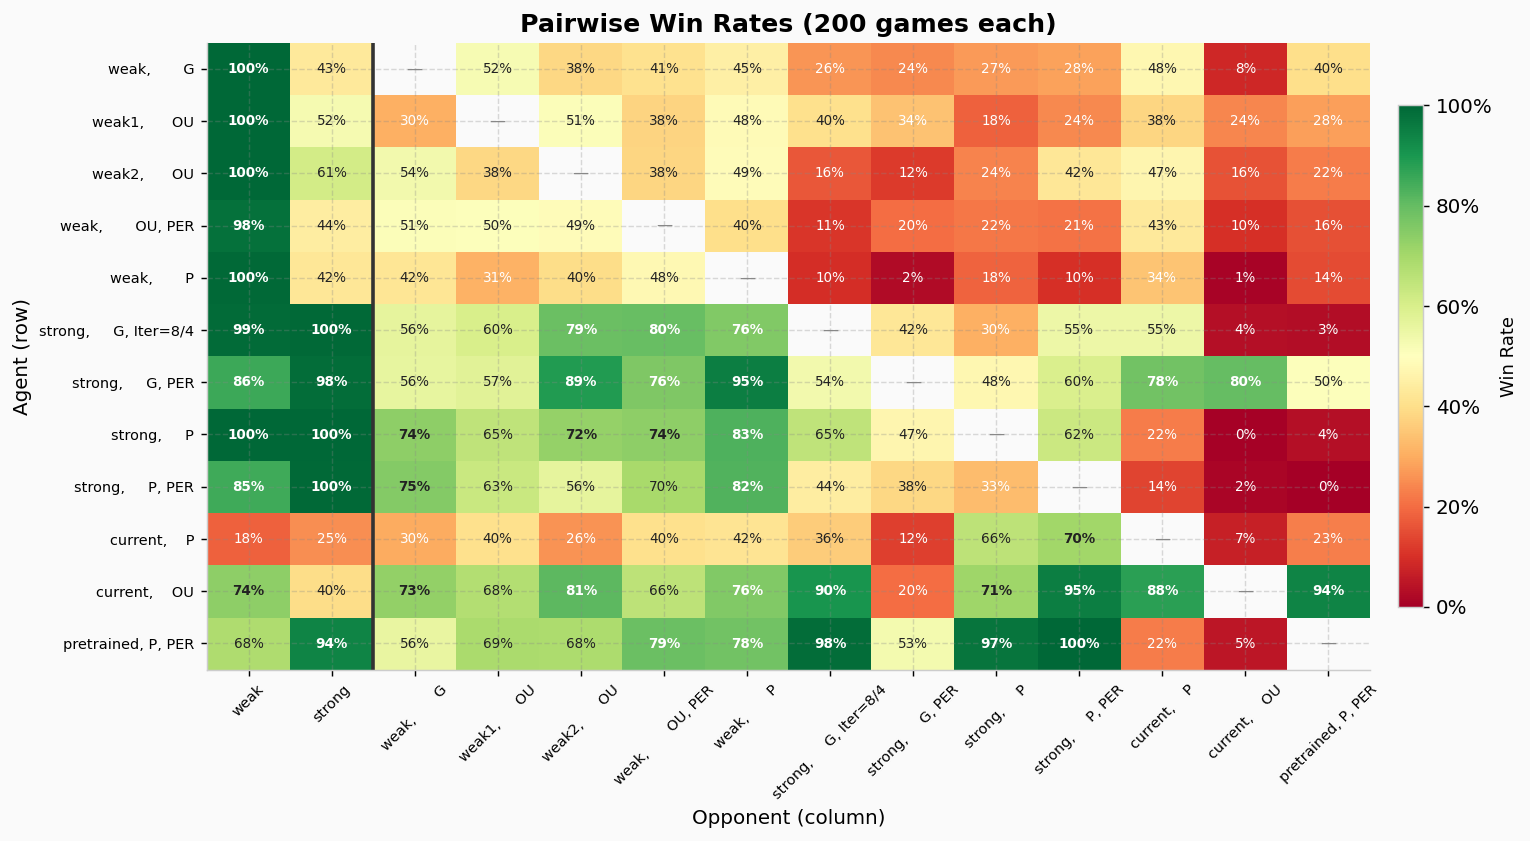

In [290]:
fig, ax = plt.subplots(figsize=(max(12, len(all_opponents) * 0.9),
                                max(6, len(agent_names) * 0.55)))

data = win_rate_matrix.values.astype(float)

im = ax.imshow(data, cmap='RdYlGn', vmin=0, vmax=1, aspect='auto')

# annotations
for i in range(len(agent_names)):
    for j in range(len(all_opponents)):
        val = data[i, j]
        if np.isnan(val):
            ax.text(j, i, '—', ha='center', va='center', fontsize=9, color='#888')
        else:
            r = results2[agent_names[i]].get(all_opponents[j])
            w, l, t = r
            color = 'white' if val < 0.35 or val > 0.75 else '#222'
            ax.text(j, i, f'{val:.0%}', #\n{w}W {l}L {t}T',
                    ha='center', va='center', fontsize=7.5, color=color,
                    fontweight='bold' if val > 0.7 else 'normal')

# axis labels
ax.set_xticks(range(len(all_opponents)))
ax.set_xticklabels(all_opponents, rotation=45, ha='center', fontsize=8)
ax.set_yticks(range(len(agent_names)))
ax.set_yticklabels(agent_names, fontsize=8, )
ax.set_xlabel('Opponent (column)', fontsize=11)
ax.set_ylabel('Agent (row)', fontsize=11)
ax.set_title(f'Pairwise Win Rates ({N_GAMES} games each)')

# colorbar
cbar = fig.colorbar(im, ax=ax, shrink=0.8, pad=0.02)
cbar.ax.set_ylabel('Win Rate', fontsize=10)
cbar.ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1.0))

# divider line between basic opponents and agent matchups
ax.axvline(1.5, color='#333', linewidth=2, linestyle='-')

plt.tight_layout()
plt.savefig('pairwise_heatmap.png')
plt.show()

In [291]:
# Compute overall stats per agent
ranking = []
for name in agent_names:
    total_w, total_l, total_t, n_matchups = 0, 0, 0, 0
    for opp in all_opponents:
        r = results2[name].get(opp)
        if r is not None:
            w, l, t = r
            total_w += w
            total_l += l
            total_t += t
            n_matchups += 1
    total_games = total_w + total_l + total_t
    ranking.append({
        'agent': name,
        'matchups': n_matchups,
        'wins': total_w,
        'losses': total_l,
        'ties': total_t,
        'win_rate': total_w / total_games if total_games > 0 else 0,
        'loss_rate': total_l / total_games if total_games > 0 else 0,
    })

ranking_df = pd.DataFrame(ranking).sort_values('win_rate', ascending=True)
ranking_df

agent  matchups  wins  losses  ties  win_rate  loss_rate
4             weak,       P        13   786    1537   277  0.302308   0.591154
9             current,    P        13   872    1266   462  0.335385   0.486923
3       weak,       OU, PER        13   950    1387   263  0.365385   0.533462
2            weak2,      OU        13  1040    1368   192  0.400000   0.526154
0             weak,       G        13  1044    1273   283  0.401538   0.489615
1            weak1,      OU        13  1054    1330   216  0.405385   0.511538
8        strong,     P, PER        13  1324    1135   141  0.509231   0.436538
5   strong,     G, Iter=8/4        13  1475     977   148  0.567308   0.375769
7             strong,     P        13  1537     886   177  0.591154   0.340769
11       pretrained, P, PER        13  1776     645   179  0.683077   0.248077
6        strong,     G, PER        13  1853     614   133  0.712692   0.236154
10           current,    OU        13  1867     332   401  0.718077   0.127692

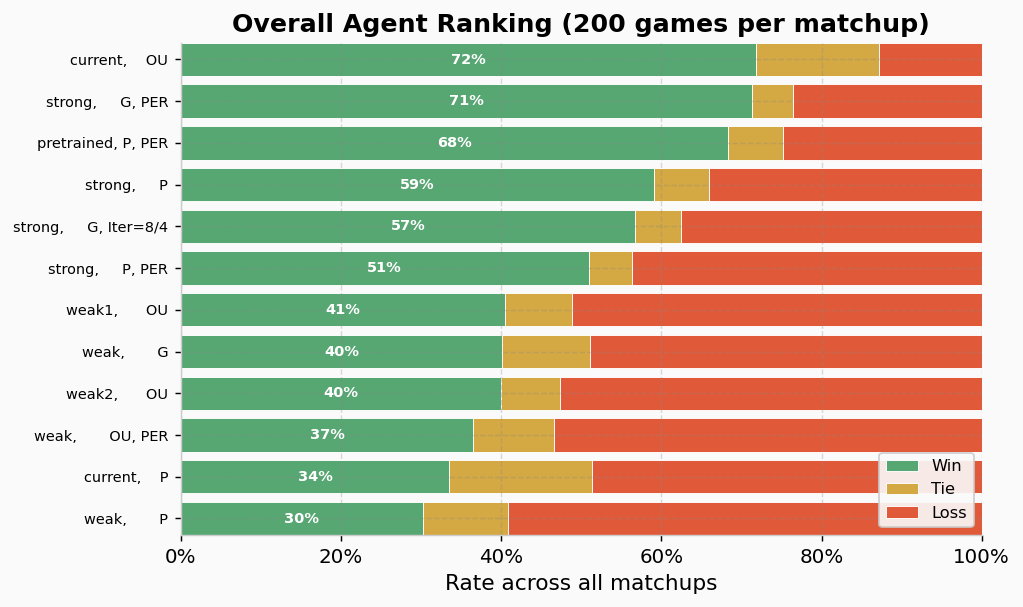

In [292]:
fig, ax = plt.subplots(figsize=(8, max(4, len(agent_names) * 0.4)))

y = range(len(ranking_df))
bar_w = ranking_df['win_rate'].values
bar_l = ranking_df['loss_rate'].values
bar_t = 1.0 - bar_w - bar_l

ax.barh(y, bar_w, color='#57A773', label='Win', edgecolor='white', linewidth=0.5)
ax.barh(y, bar_t, left=bar_w, color='#D4A843', label='Tie', edgecolor='white', linewidth=0.5)
ax.barh(y, bar_l, left=bar_w + bar_t, color='#E05A3A', label='Loss', edgecolor='white', linewidth=0.5)

# labels
for i, (_, row) in enumerate(ranking_df.iterrows()):
    ax.text(row['win_rate'] / 2, i, f"{row['win_rate']:.0%}",
            ha='center', va='center', fontsize=8, fontweight='bold', color='white')

ax.set_yticks(y)
ax.set_yticklabels(ranking_df['agent'].values, fontsize=8)
ax.set_xlim(0, 1)
ax.xaxis.set_major_formatter(ticker.PercentFormatter(xmax=1.0))
ax.set_xlabel('Rate across all matchups')
ax.set_title(f'Overall Agent Ranking ({N_GAMES} games per matchup)')
ax.legend(loc='lower right', fontsize=9)

plt.tight_layout()
plt.savefig('agent_ranking.png')
plt.show()

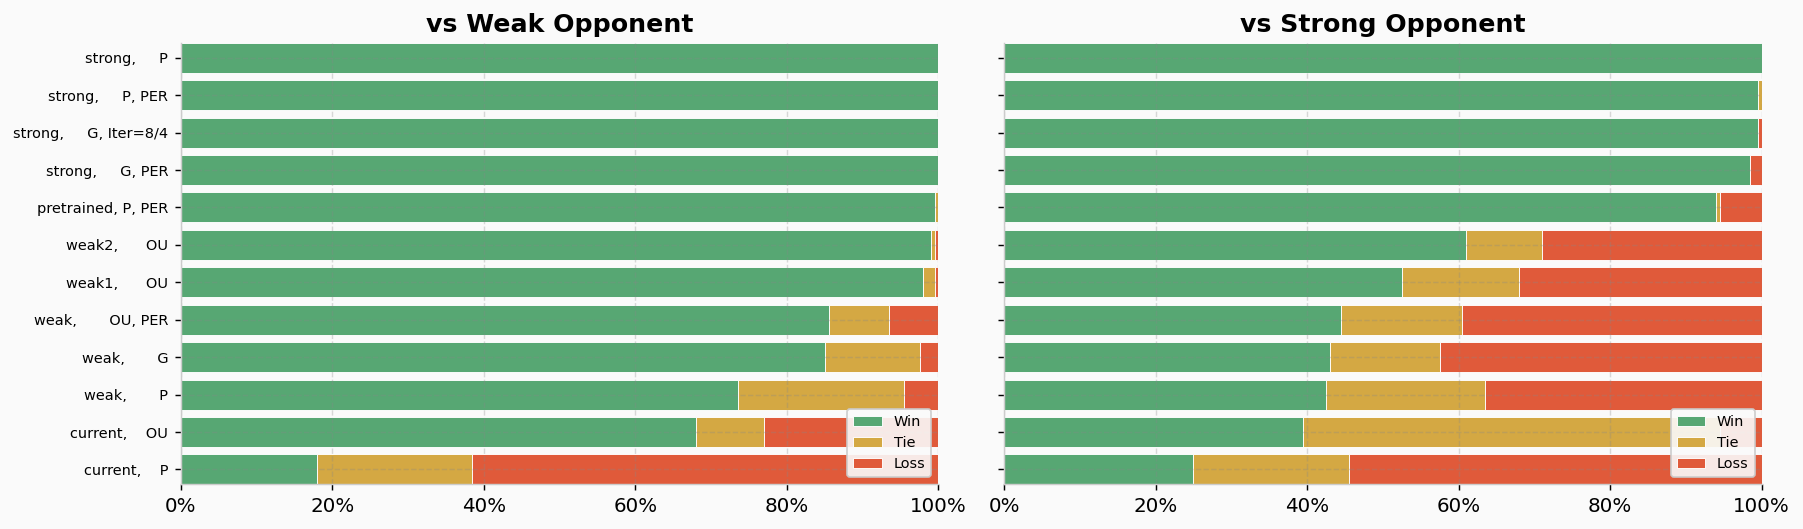

In [293]:
fig, axes = plt.subplots(1, 2, figsize=(14, max(4, len(agent_names) * 0.35)),
                         sharey=True)

for ax, opp_type in zip(axes, ['weak', 'strong']):
    rates = []
    for name in agent_names:
        r = results2[name][opp_type]
        w, l, t = r
        rates.append({'agent': name, 'Win': w/N_GAMES, 'Tie': t/N_GAMES, 'Loss': l/N_GAMES})
    df = pd.DataFrame(rates).sort_values('Win', ascending=True)

    y = range(len(df))
    ax.barh(y, df['Win'],  color='#57A773', label='Win',  edgecolor='white', linewidth=0.5)
    ax.barh(y, df['Tie'],  left=df['Win'], color='#D4A843', label='Tie', edgecolor='white', linewidth=0.5)
    ax.barh(y, df['Loss'], left=df['Win']+df['Tie'], color='#E05A3A', label='Loss', edgecolor='white', linewidth=0.5)

    ax.set_yticks(y)
    ax.set_yticklabels(df['agent'].values, fontsize=8)
    ax.set_xlim(0, 1)
    ax.xaxis.set_major_formatter(ticker.PercentFormatter(xmax=1.0))
    ax.set_title(f'vs {opp_type.capitalize()} Opponent')
    ax.legend(loc='lower right', fontsize=8)

plt.tight_layout()
plt.savefig('vs_basic_opponents.png')
plt.show()

# Win rates throughout training

In [234]:
# load the jobs for which win rate logs exist
JOB_IDs = {
           "Opponent: strong, Iter=1, Pink, Prioritized ER": "1986341",
           "Opponent: strong, Iter=1, Gaussian, Prioritized ER": "1986633",
           "Opponent: weak, Iter=1, Ornstein-Uhlenbeck, normal buffer": "1986415",
           "Opponent: weak, Iter=1, Ornstein, Prioritized ER": "1986413",
           "Opponent: current self, Iter=1, Pink": "1986278",
           "Opponent: current self, Iter=1, Ornstein": "1986284",
           "Opponent: pretrained self, Iter=1, Pink, Prioritized ER": "1986931",
           } 
paths_map = {name: f"./{job_id}/logs/win_rate_log.csv" for name, job_id in JOB_IDs.items()}


In [235]:
runs = {}
for name, path in paths_map.items():
    df = pd.read_csv(path)
    df.columns = df.columns.str.strip()
    runs[name] = df
    print(f"{name}: {len(df)} episodes, "
        f"{df['total_steps'].iloc[-1]} total steps, "
        )

Opponent: strong, Iter=1, Pink, Prioritized ER: 250 episodes, 2290041 total steps, 
Opponent: strong, Iter=1, Gaussian, Prioritized ER: 250 episodes, 2088600 total steps, 
Opponent: weak, Iter=1, Ornstein-Uhlenbeck, normal buffer: 250 episodes, 3244910 total steps, 
Opponent: weak, Iter=1, Ornstein, Prioritized ER: 250 episodes, 2910178 total steps, 
Opponent: current self, Iter=1, Pink: 250 episodes, 11782223 total steps, 
Opponent: current self, Iter=1, Ornstein: 250 episodes, 11326407 total steps, 
Opponent: pretrained self, Iter=1, Pink, Prioritized ER: 50 episodes, 517603 total steps, 


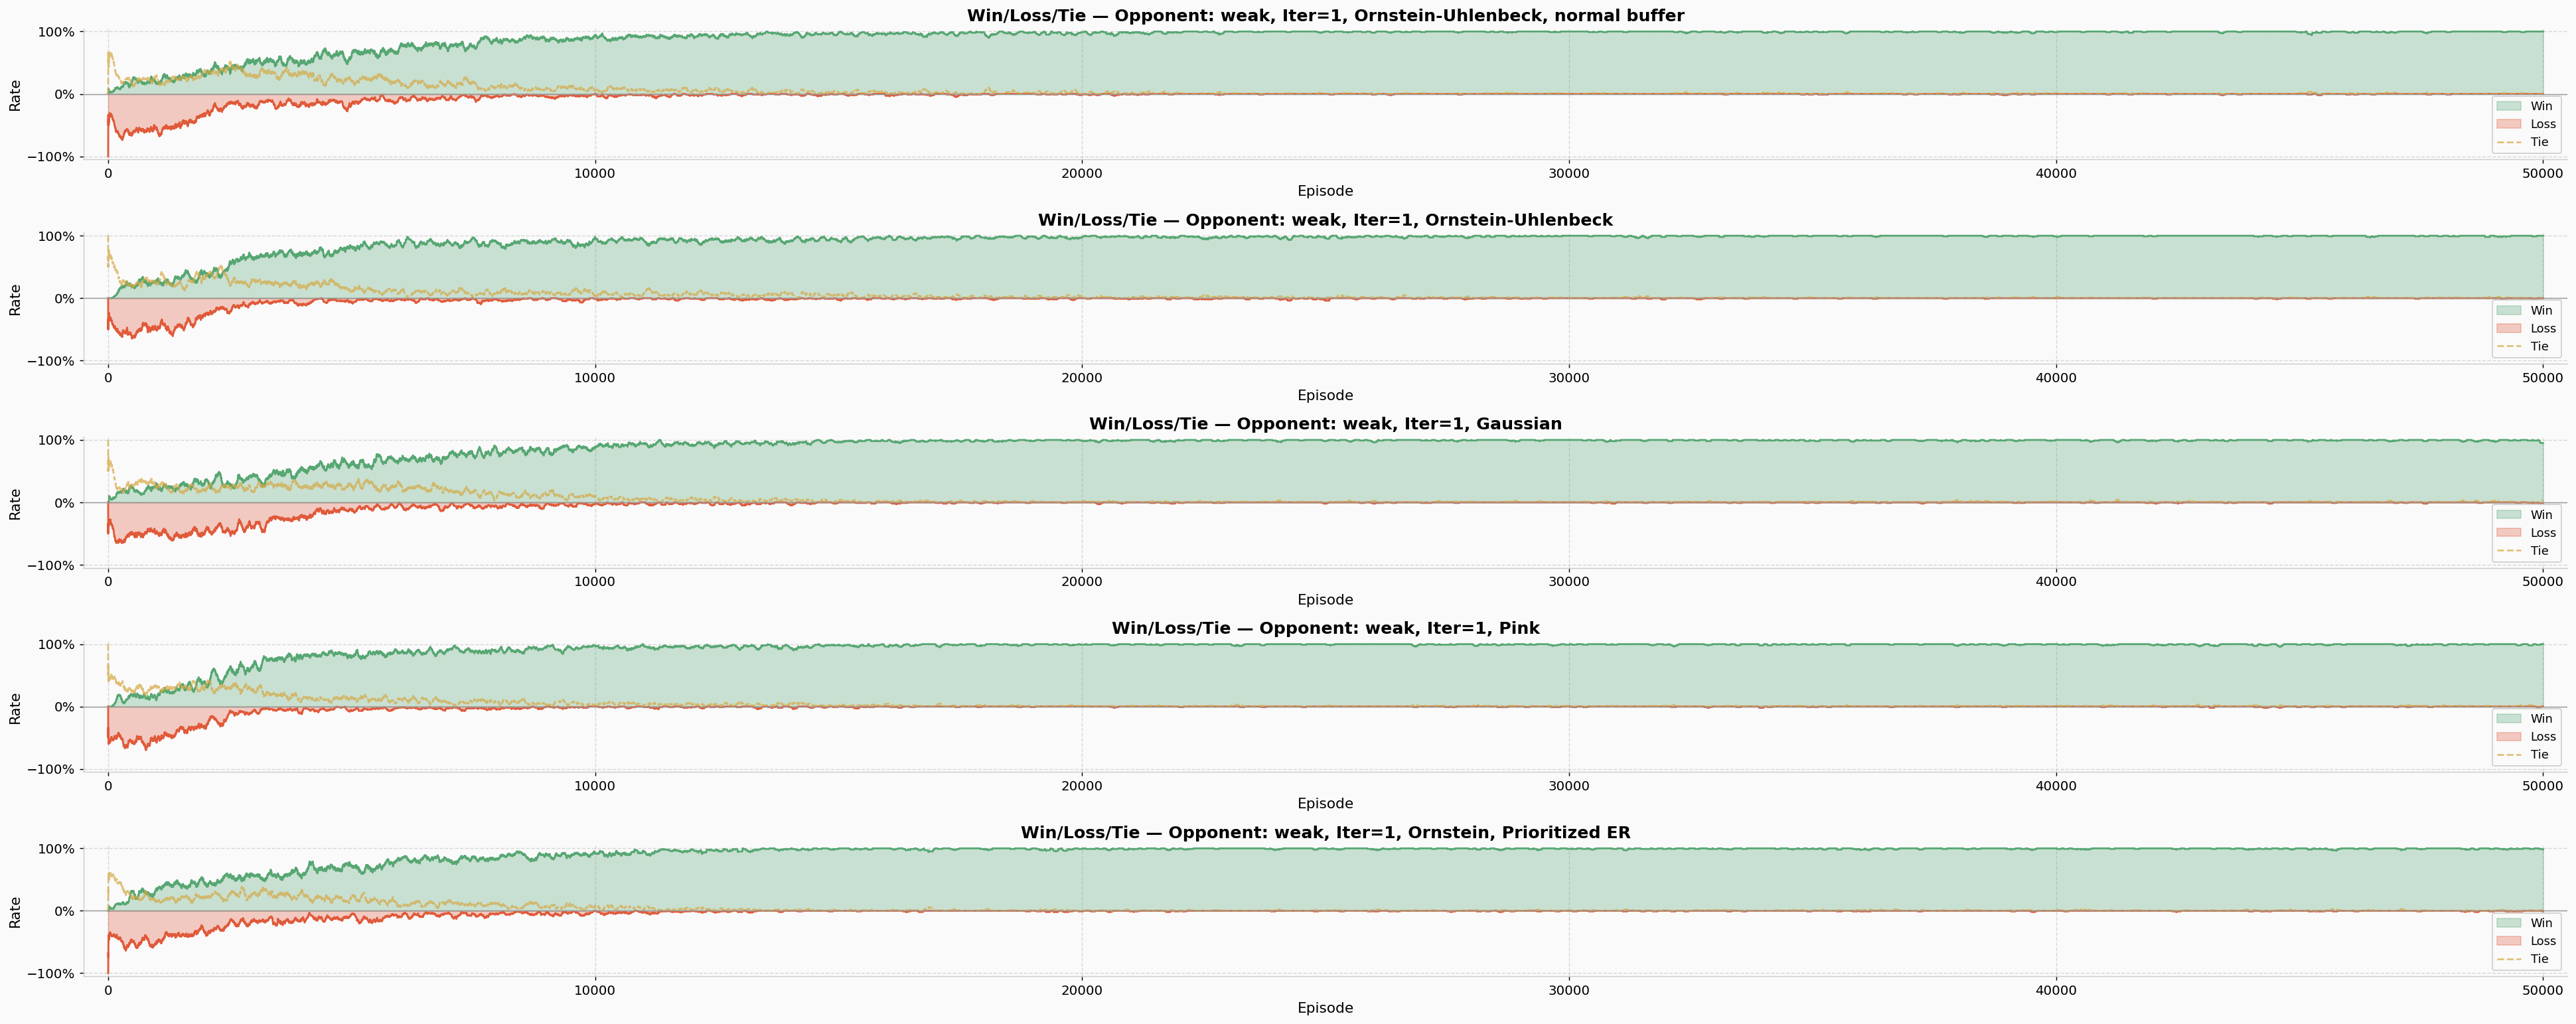

In [253]:
n_runs = len(runs)
fig, axes = plt.subplots(n_runs, 1, figsize=(6 * n_runs, 12), squeeze=False)

for i, (name, df) in enumerate(runs.items()):
    ax = axes[i, 0]
    ax.fill_between(df['episode'], 0, df['win_rate'],
                    alpha=0.3, color='#57A773', label='Win')
    ax.fill_between(df['episode'], 0, -df['loss_rate'],
                    alpha=0.3, color='#E05A3A', label='Loss')
    ax.plot(df['episode'], df['win_rate'],  color='#57A773', linewidth=1.5)
    ax.plot(df['episode'], -df['loss_rate'], color='#E05A3A', linewidth=1.5)
    ax.plot(df['episode'], df['tie_rate'],  color='#D4A843', linewidth=1.5,
            alpha=0.7, label='Tie', linestyle='--')
    ax.axhline(0, color='#999999', linewidth=0.8)
    ax.set_ylim(-1.05, 1.05)
    ax.set_xlabel('Episode')
    ax.set_ylabel('Rate')
    ax.set_title(f'Win/Loss/Tie — {name}')
    ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1.0))
    ax.legend(loc='lower right')

plt.tight_layout()
plt.show()

# General analysis (incl. derived statistics)

In [237]:
# load the data 
JOB_IDs = {#"Opponent: strong, Iter=1, Gaussian/Orn": "1985807", 
           #"Opponent: strong, Iter=8/4, Gauss/Orn": "1985808",
           #"Opponent: strong, Iter=1, Pink": "1986229",
           #"Opponent: strong, Iter=1, Pink, Prioritized ER": "1986341",
           #"Opponent: strong, Iter=1, Gaussian, Prioritized ER": "1986633",
           #"Opponent: pretrained self, Iter=1, Pink, Prioritized ER": "1986931",
           #"Opponent: current self, Iter=1, Pink": "1986278",
           #"Opponent: current self, Iter=1, Ornstein": "1986284",
           "Opponent: weak, Iter=1, Ornstein-Uhlenbeck, normal buffer": "1986415",
           "Opponent: weak, Iter=1, Ornstein-Uhlenbeck": "1986036", # slightly lower win rate in eval
           "Opponent: weak, Iter=1, Gaussian": "1985908", # can also have 99.5% seldomly
           "Opponent: weak, Iter=1, Pink": "1986002", # slightly lower win rate (99.5%)
           "Opponent: weak, Iter=1, Ornstein, Prioritized ER": "1986413",
           } 
paths_map = {name: f"./{job_id}/logs/training_log.csv" for name, job_id in JOB_IDs.items()}


In [238]:
paths_map

{'Opponent: weak, Iter=1, Ornstein-Uhlenbeck, normal buffer': './1986415/logs/training_log.csv',
 'Opponent: weak, Iter=1, Ornstein-Uhlenbeck': './1986036/logs/training_log.csv',
 'Opponent: weak, Iter=1, Gaussian': './1985908/logs/training_log.csv',
 'Opponent: weak, Iter=1, Pink': './1986002/logs/training_log.csv',
 'Opponent: weak, Iter=1, Ornstein, Prioritized ER': './1986413/logs/training_log.csv'}

In [239]:
# STYLE SETUP
plt.rcParams.update({
    'figure.facecolor':     '#fafafa',
    'axes.facecolor':       '#fafafa',
    'axes.edgecolor':       '#cccccc',
    'axes.grid':            True,
    'axes.spines.top':      False,
    'axes.spines.right':    False,
    'axes.xmargin':         0.01,
    'axes.ymargin':         0.0,   
    'grid.alpha':           0.3,
    'grid.color':           '#888888',
    'grid.linestyle':       '--',
    'font.family':          'sans-serif',
    'font.size':            11,
    'axes.titlesize':       14,
    'axes.titleweight':     'bold',
    'axes.labelsize':       12,
    'legend.fontsize':      10,
    'legend.framealpha':    0.9,
    'legend.edgecolor':     '#cccccc',
    'figure.dpi':           130,
    'savefig.dpi':          200,
    'savefig.bbox':         'tight',
})

COLORS = ['#2176AE', # blue
          '#57A773', # green
          '#D4A843', # yellow
          '#E87EA1', # pink
          '#E05A3A', # orange
          '#8B5FBF', # purple
          ]

SMOOTHING_WINDOW = 100

def get_color(i):
    return COLORS[i % len(COLORS)]

In [240]:
# ** LOAD DATA **
def load_training_data(paths_map) -> dict:
    runs = {}
    for name, path in paths_map.items():
        df = pd.read_csv(path)
        df.columns = df.columns.str.strip()
        # derive smoothed values for calmer plots
        df['smoothed_episode_reward'] = df['episode_reward'].rolling(SMOOTHING_WINDOW,
                                                                    min_periods=1).mean()
        df['win']  = (df['winner'] == 1).astype(int)
        df['loss'] = (df['winner'] == -1).astype(int)
        df['tie']  = (df['winner'] == 0).astype(int)
        df['win_rate']  = df['win'].rolling(SMOOTHING_WINDOW, min_periods=1).mean()
        df['loss_rate'] = df['loss'].rolling(SMOOTHING_WINDOW, min_periods=1).mean()
        df['tie_rate']  = df['tie'].rolling(SMOOTHING_WINDOW, min_periods=1).mean()
        
        runs[name] = df
        print(f"{name}: {len(df)} episodes, "
            f"{df['total_steps'].iloc[-1]} total steps, "
            )
    return runs

runs = load_training_data(paths_map=paths_map)

Opponent: weak, Iter=1, Ornstein-Uhlenbeck, normal buffer: 50000 episodes, 3244910 total steps, 
Opponent: weak, Iter=1, Ornstein-Uhlenbeck: 50000 episodes, 3240003 total steps, 
Opponent: weak, Iter=1, Gaussian: 50000 episodes, 3401496 total steps, 


Opponent: weak, Iter=1, Pink: 50000 episodes, 2866549 total steps, 
Opponent: weak, Iter=1, Ornstein, Prioritized ER: 50000 episodes, 2910178 total steps, 


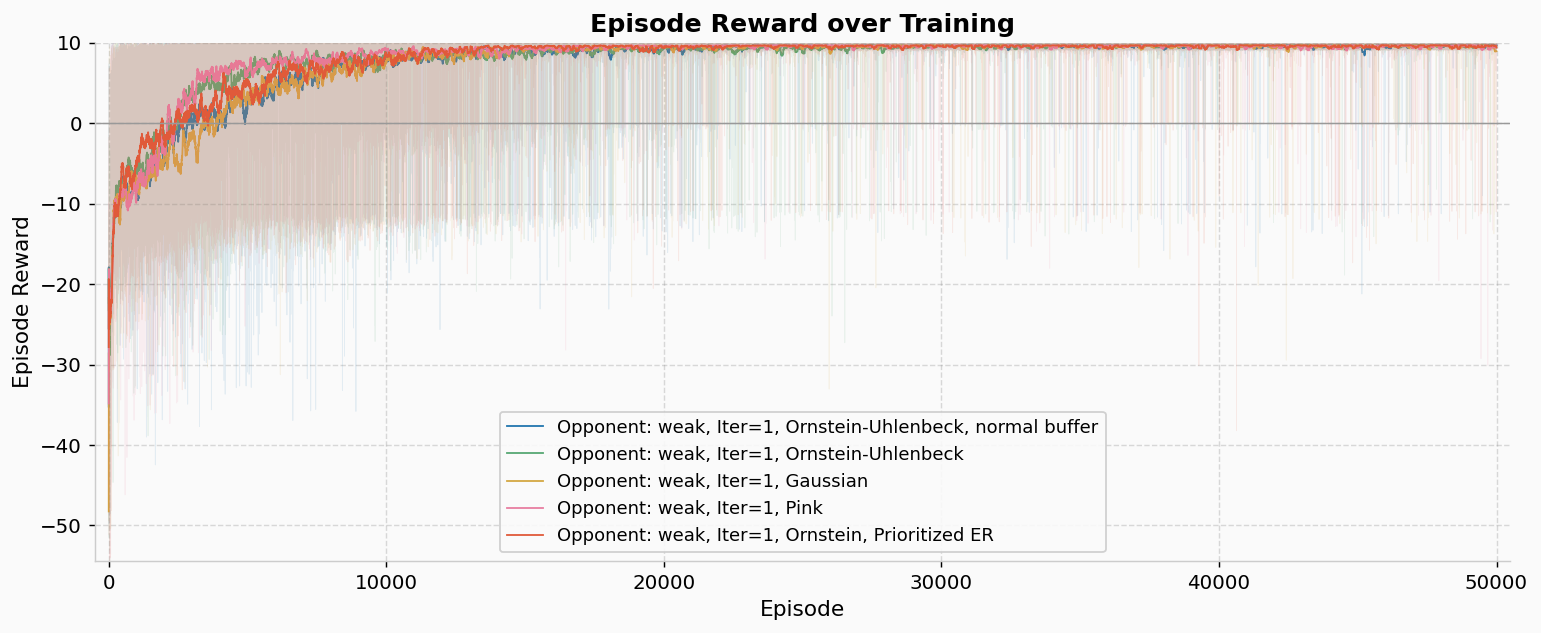

In [241]:
fig, ax = plt.subplots(figsize=(12, 5))
for i, (name, df) in enumerate(runs.items()):
    c = get_color(i)
    ax.plot(df['episode'], df['episode_reward'], 
            alpha=0.1, color=c, linewidth=0.5)
    ax.plot(df['episode'], df['smoothed_episode_reward'], 
            color=c, linewidth=1,
            label=name)
ax.set_xlabel('Episode')
ax.set_ylabel('Episode Reward')
ax.set_title('Episode Reward over Training')
ax.legend()
ax.axhline(0, color='#999999', linewidth=0.8, linestyle='-')
plt.tight_layout()
plt.show()

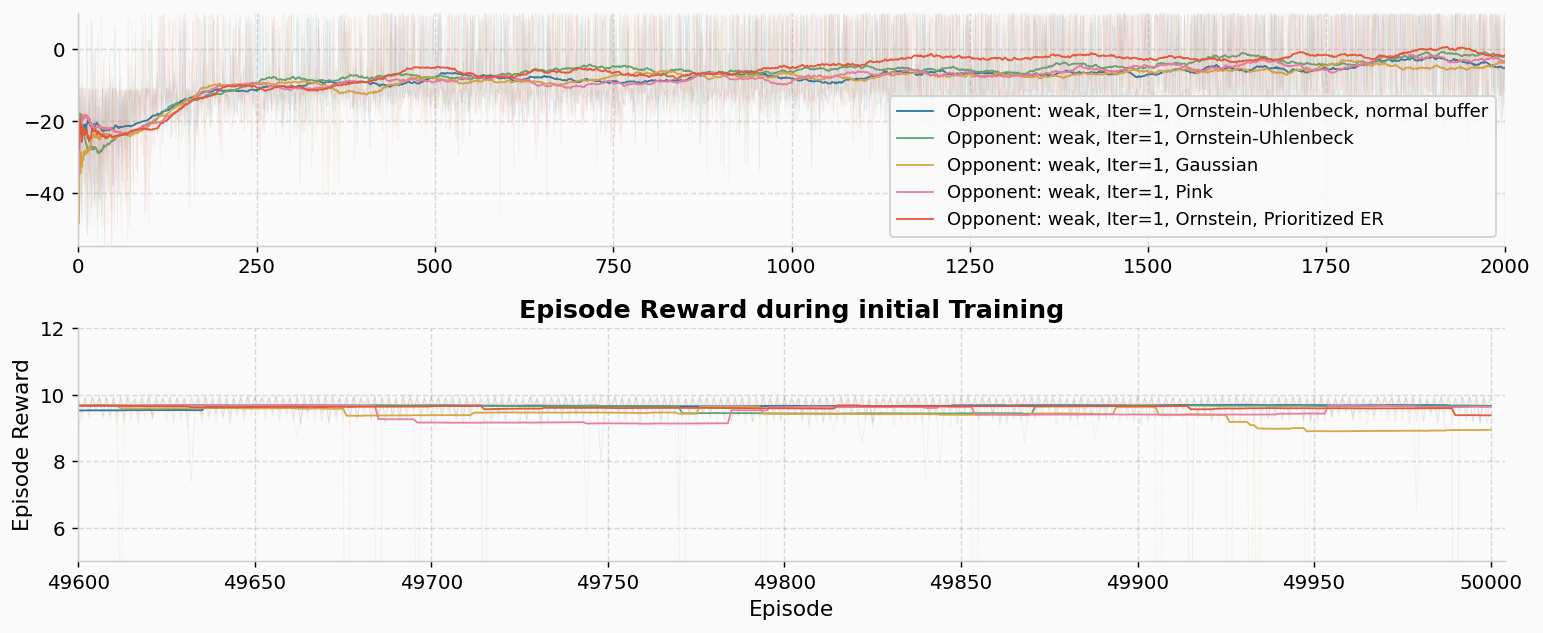

In [242]:
# close up
EPISODE_MAX = 2000
EPISODE_MIN = 49_600

windows = [
    ("Early training", lambda df: df[df["episode"] <= EPISODE_MAX], (0, EPISODE_MAX)),
    ("Late training",  lambda df: df[df["episode"] >= EPISODE_MIN], (EPISODE_MIN, None)),
]

fig, axes = plt.subplots(2, 1, figsize=(12, 5))
for j, (title, filter, xlim) in enumerate(windows):
        for i, (name, df) in enumerate(runs.items()):
                ax = axes[j]
                c = get_color(i)
                d = filter(df)
                ax.plot(d['episode'], d['episode_reward'], 
                        alpha=0.1, color=c, linewidth=0.5)
                ax.plot(d['episode'], d['smoothed_episode_reward'], 
                        color=c, linewidth=1,
                        label=name)
        if xlim[1] is None:
                ax.set_xlim(left=xlim[0])
        else:
                ax.set_xlim(*xlim)
axes[-1].set_ylim(bottom=5, top=12)
axes[-1].set_xlabel("Episode")
axes[0].legend()
ax.set_xlabel('Episode')
ax.set_ylabel('Episode Reward')
ax.set_title('Episode Reward during initial Training')
ax.axhline(0, color='#999999', linewidth=0.8, linestyle='-')
plt.tight_layout()
plt.show()

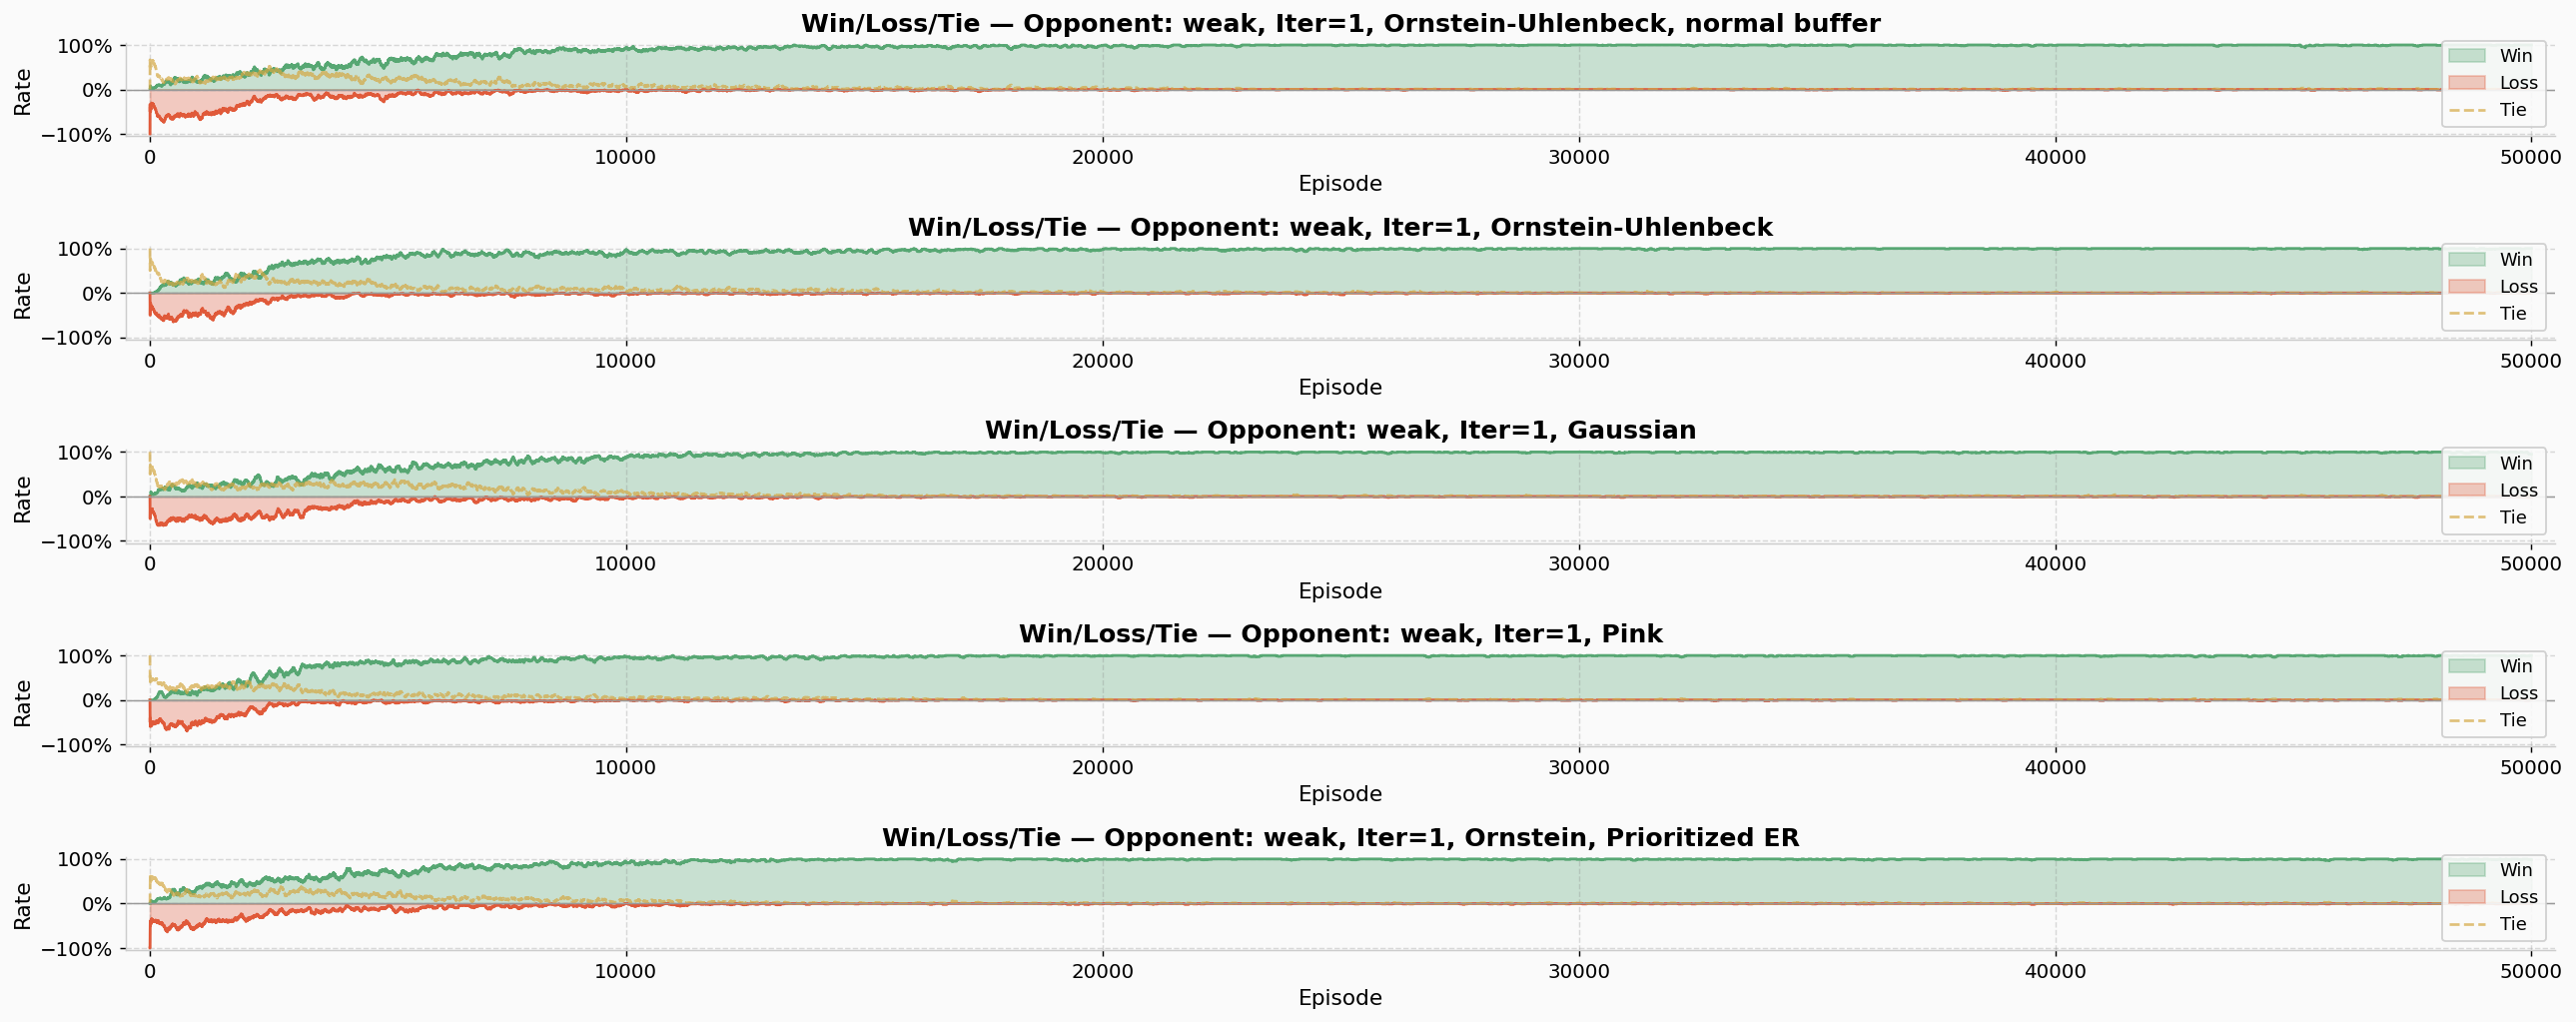

In [243]:
n_runs = len(runs)
fig, axes = plt.subplots(n_runs, 1, figsize=(4 * n_runs, 8), squeeze=False)

for i, (name, df) in enumerate(runs.items()):
    ax = axes[i, 0]
    ax.fill_between(df['episode'], 0, df['win_rate'],
                    alpha=0.3, color='#57A773', label='Win')
    ax.fill_between(df['episode'], 0, -df['loss_rate'],
                    alpha=0.3, color='#E05A3A', label='Loss')
    ax.plot(df['episode'], df['win_rate'],  color='#57A773', linewidth=1.5)
    ax.plot(df['episode'], -df['loss_rate'], color='#E05A3A', linewidth=1.5)
    ax.plot(df['episode'], df['tie_rate'],  color='#D4A843', linewidth=1.5,
            alpha=0.7, label='Tie', linestyle='--')
    ax.axhline(0, color='#999999', linewidth=0.8)
    ax.set_ylim(-1.05, 1.05)
    ax.set_xlabel('Episode')
    ax.set_ylabel('Rate')
    ax.set_title(f'Win/Loss/Tie — {name}')
    ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1.0))
    ax.legend(loc='lower right')

plt.tight_layout()
plt.show()

In [244]:
# validate win rate every 100 episodes
# see further up


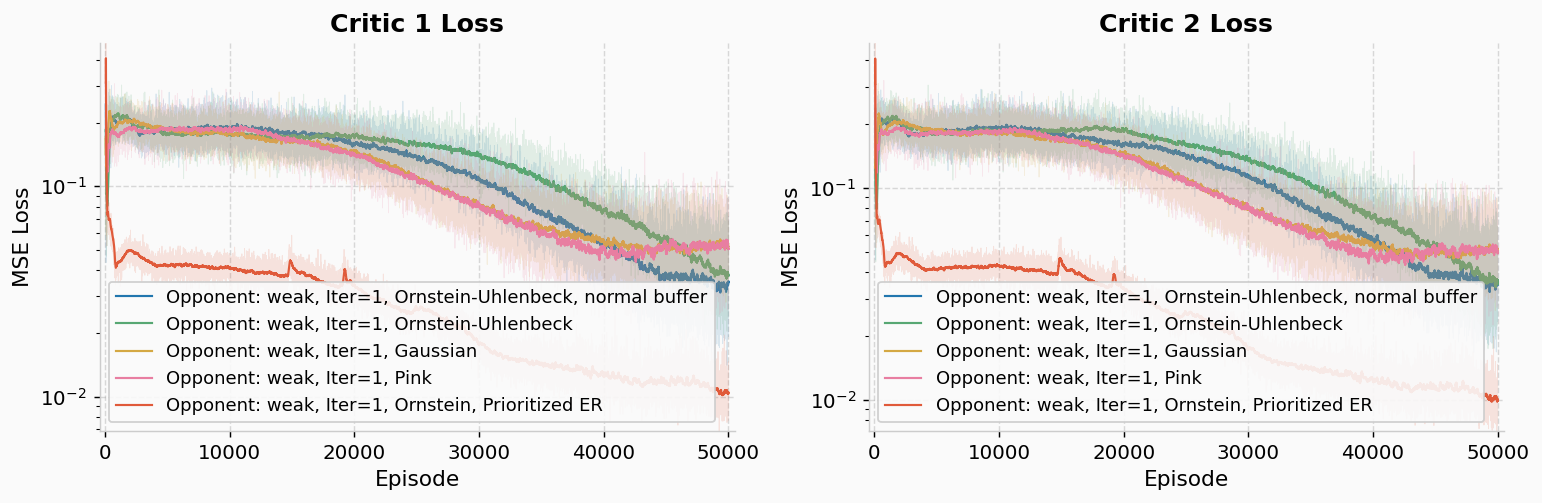

In [245]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

for i, (name, df) in enumerate(runs.items()):
    c = get_color(i)
    # Filter out zeros (episodes before warmup)
    mask = df['critic1_loss'] > 0
    ep = df.loc[mask, 'episode']

    for j, col in enumerate(['critic1_loss', 'critic2_loss']):
        ax = axes[j]
        raw = df.loc[mask, col]
        smooth = raw.rolling(SMOOTHING_WINDOW, min_periods=1).mean()
        ax.plot(ep, raw, alpha=0.15, color=c, linewidth=0.5)
        ax.plot(ep, smooth, color=c, linewidth=1.2, label=name)

for j, title in enumerate(['Critic 1 Loss', 'Critic 2 Loss']):
    axes[j].set_xlabel('Episode')
    axes[j].set_ylabel('MSE Loss')
    axes[j].set_title(title)
    axes[j].legend()
    axes[j].set_yscale('log')

plt.tight_layout()
plt.show()

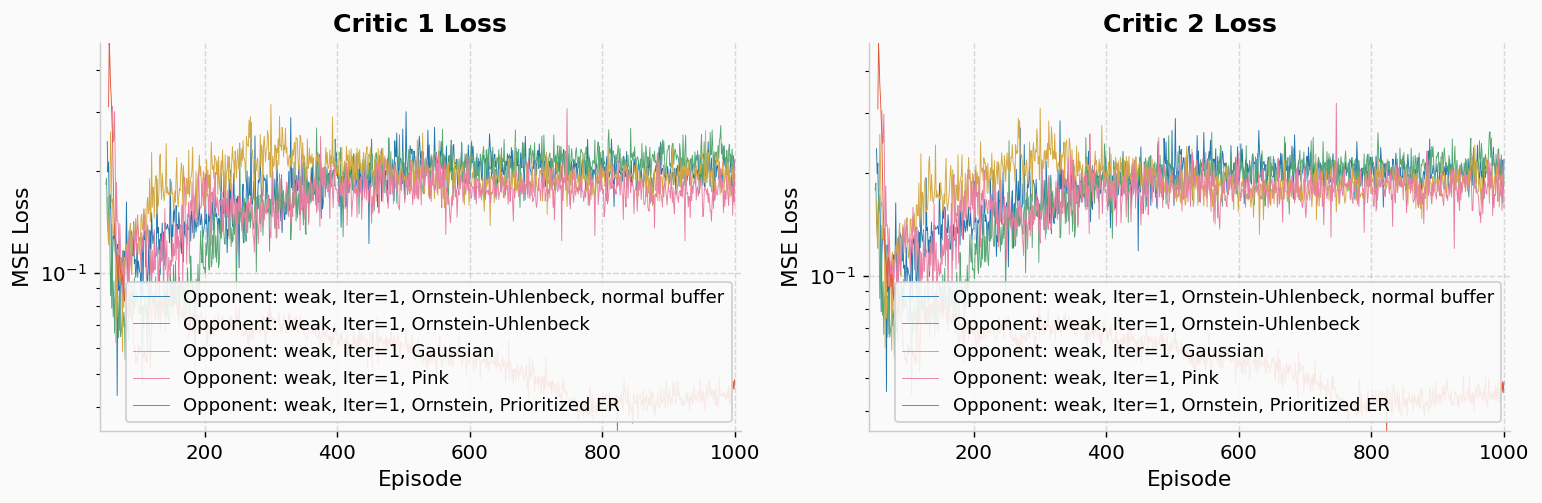

In [246]:
# zoom in to the beginning
EPISODE_MAX = 1000

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

for i, (name, df) in enumerate(runs.items()):
    c = get_color(i)
    d = df[df["episode"] <= EPISODE_MAX]

    # Filter out zeros (episodes before warmup)
    mask = d['critic1_loss'] > 0
    ep = d.loc[mask, 'episode']

    for j, col in enumerate(['critic1_loss', 'critic2_loss']):
        ax = axes[j]
        raw = d.loc[mask, col]
        smooth = raw.rolling(SMOOTHING_WINDOW, min_periods=1).mean()
        ax.plot(ep, raw, alpha=1, color=c, linewidth=0.5, label=name)
        #ax.plot(ep, smooth, color=c, linewidth=2, label=name)

for j, title in enumerate(['Critic 1 Loss', 'Critic 2 Loss']):
    axes[j].set_xlabel('Episode')
    axes[j].set_ylabel('MSE Loss')
    axes[j].set_title(title)
    axes[j].legend()
    axes[j].set_yscale('log')

plt.tight_layout()
plt.show()

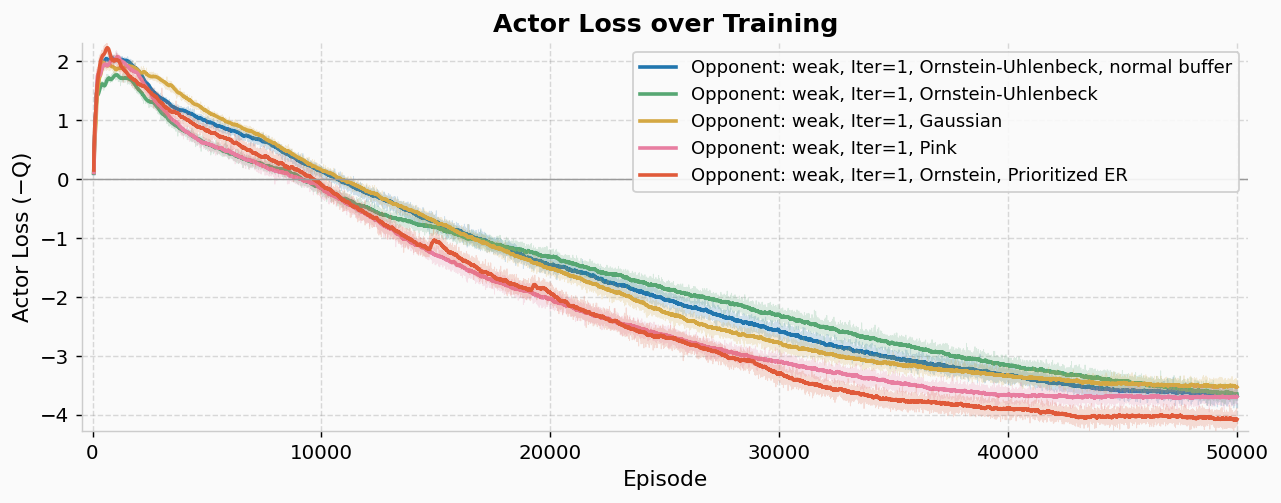

In [247]:
fig, ax = plt.subplots(figsize=(10, 4))
for i, (name, df) in enumerate(runs.items()):
    c = get_color(i)
    mask = df['actor_loss'] != 0
    ep = df.loc[mask, 'episode']
    raw = df.loc[mask, 'actor_loss']
    smooth = raw.rolling(SMOOTHING_WINDOW, min_periods=1).mean()
    ax.plot(ep, raw, alpha=0.2, color=c, linewidth=0.5)
    ax.plot(ep, smooth, color=c, linewidth=2, label=name)
ax.set_xlabel('Episode')
ax.set_ylabel('Actor Loss (−Q)')
ax.set_title('Actor Loss over Training')
ax.legend()
ax.axhline(0, color='#999999', linewidth=0.8, linestyle='-')
plt.tight_layout()
plt.show()

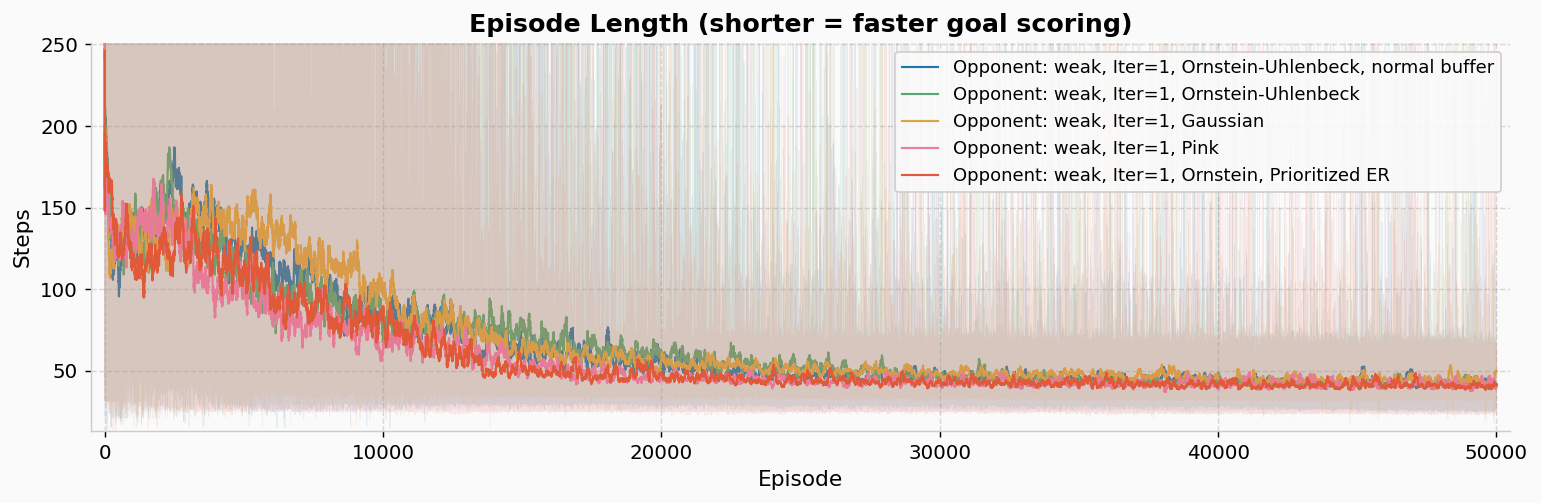

In [248]:
fig, ax = plt.subplots(figsize=(12, 4))
for i, (name, df) in enumerate(runs.items()):
    c = get_color(i)
    smooth = df['episode_length'].rolling(SMOOTHING_WINDOW, min_periods=1).mean()
    ax.plot(df['episode'], df['episode_length'], alpha=0.1, color=c, linewidth=0.5)
    ax.plot(df['episode'], smooth, color=c, linewidth=1.2, label=name)
#ax.axhline(250, color='#999999', linewidth=1, linestyle=':', label='Max (250)')
ax.set_xlabel('Episode')
ax.set_ylabel('Steps')
ax.set_title('Episode Length (shorter = faster goal scoring)')
ax.legend()
plt.tight_layout()
plt.show()

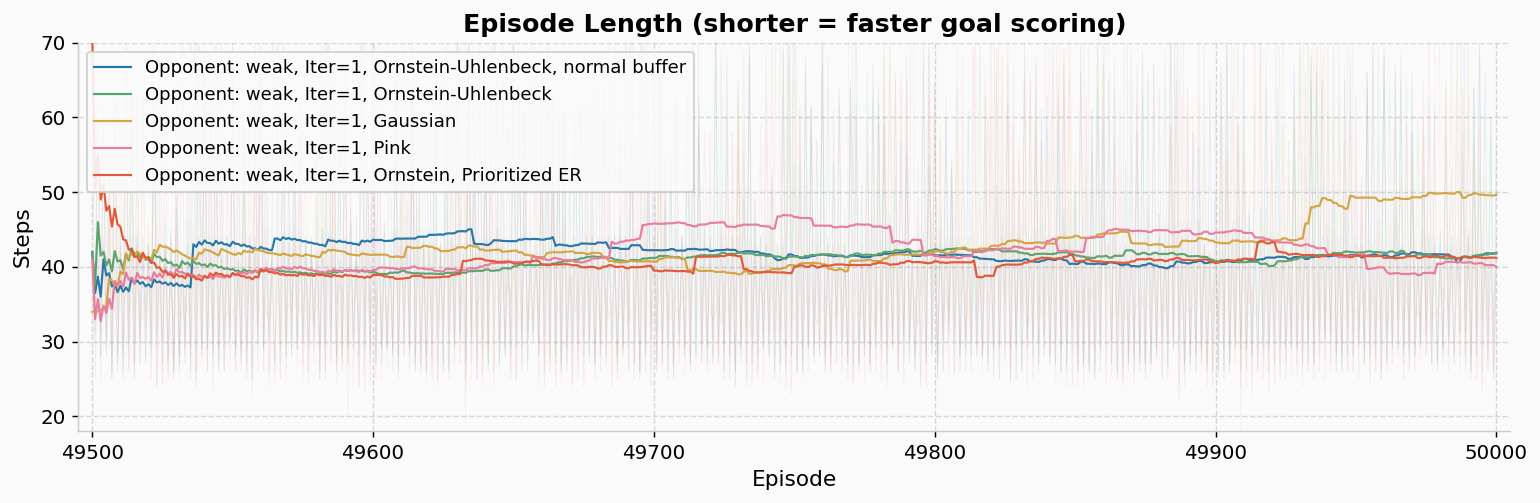

In [249]:
# zoom into the end
EPISODE_MIN = 49_500

fig, ax = plt.subplots(figsize=(12, 4))
for i, (name, df) in enumerate(runs.items()):
    c = get_color(i)
    d = df[df["episode"] >= EPISODE_MIN]
    smooth = d['episode_length'].rolling(SMOOTHING_WINDOW, min_periods=1).mean()
    ax.plot(d['episode'], d['episode_length'], alpha=0.1, color=c, linewidth=0.5)
    ax.plot(d['episode'], smooth, color=c, linewidth=1.2, label=name)
#ax.axhline(250, color='#999999', linewidth=1, linestyle=':', label='Max (250)')
ax.set_xlabel('Episode')
ax.set_ylim(top=70)
ax.set_ylabel('Steps')
ax.set_title('Episode Length (shorter = faster goal scoring)')
ax.legend()
plt.tight_layout()
plt.show()

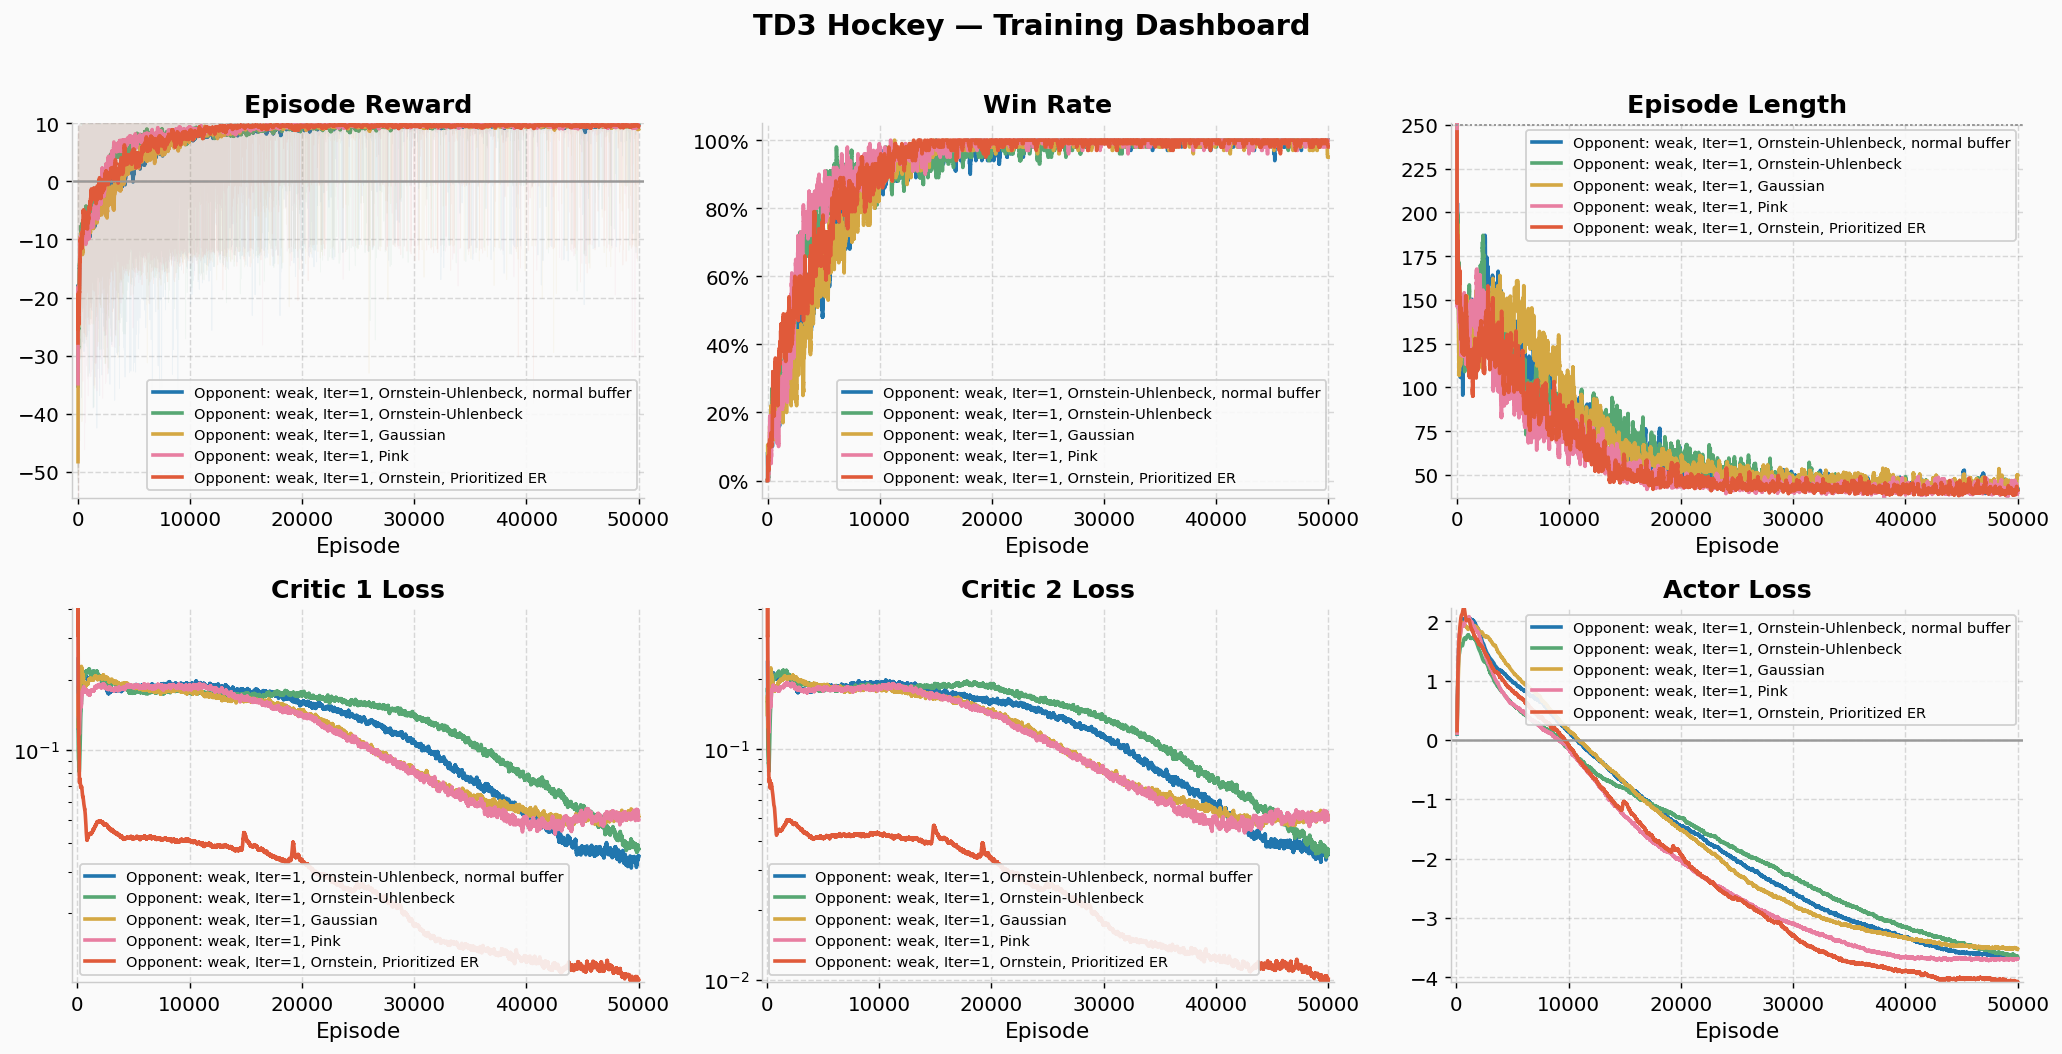

In [250]:
fig, axes = plt.subplots(2, 3, figsize=(16, 8))
fig.suptitle('TD3 Hockey — Training Dashboard', fontsize=16, fontweight='bold', y=1.01)

for i, (name, df) in enumerate(runs.items()):
    c = get_color(i)
    mask_loss = df['critic1_loss'] > 0
    mask_actor = df['actor_loss'] != 0

    # (0,0) Reward
    ax = axes[0, 0]
    ax.plot(df['episode'], df['episode_reward'], alpha=0.06, color=c, linewidth=0.5)
    ax.plot(df['episode'], df['smoothed_episode_reward'], color=c, linewidth=2, label=name)
    ax.set_title('Episode Reward')
    ax.axhline(0, color='#999999', linewidth=0.8)

    # (0,1) Win rate
    ax = axes[0, 1]
    ax.plot(df['episode'], df['win_rate'], color=c, linewidth=2, label=name)
    ax.set_title('Win Rate')
    ax.set_ylim(-0.05, 1.05)
    ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1.0))

    # (0,2) Episode length
    ax = axes[0, 2]
    smooth_len = df['episode_length'].rolling(SMOOTHING_WINDOW, min_periods=1).mean()
    ax.plot(df['episode'], smooth_len, color=c, linewidth=2, label=name)
    ax.axhline(250, color='#999999', linewidth=1, linestyle=':')
    ax.set_title('Episode Length')

    # (1,0) Critic 1
    ax = axes[1, 0]
    ep = df.loc[mask_loss, 'episode']
    smooth_c1 = df.loc[mask_loss, 'critic1_loss'].rolling(SMOOTHING_WINDOW, min_periods=1).mean()
    ax.plot(ep, smooth_c1, color=c, linewidth=2, label=name)
    ax.set_title('Critic 1 Loss')
    ax.set_yscale('log')

    # (1,1) Critic 2
    ax = axes[1, 1]
    smooth_c2 = df.loc[mask_loss, 'critic2_loss'].rolling(SMOOTHING_WINDOW, min_periods=1).mean()
    ax.plot(ep, smooth_c2, color=c, linewidth=2, label=name)
    ax.set_title('Critic 2 Loss')
    ax.set_yscale('log')

    # (1,2) Actor loss
    ax = axes[1, 2]
    ep_a = df.loc[mask_actor, 'episode']
    smooth_a = df.loc[mask_actor, 'actor_loss'].rolling(SMOOTHING_WINDOW, min_periods=1).mean()
    ax.plot(ep_a, smooth_a, color=c, linewidth=2, label=name)
    ax.set_title('Actor Loss')
    ax.axhline(0, color='#999999', linewidth=0.8)

for ax in axes.flat:
    ax.set_xlabel('Episode')
    ax.legend(fontsize=8)

plt.tight_layout()
plt.show()

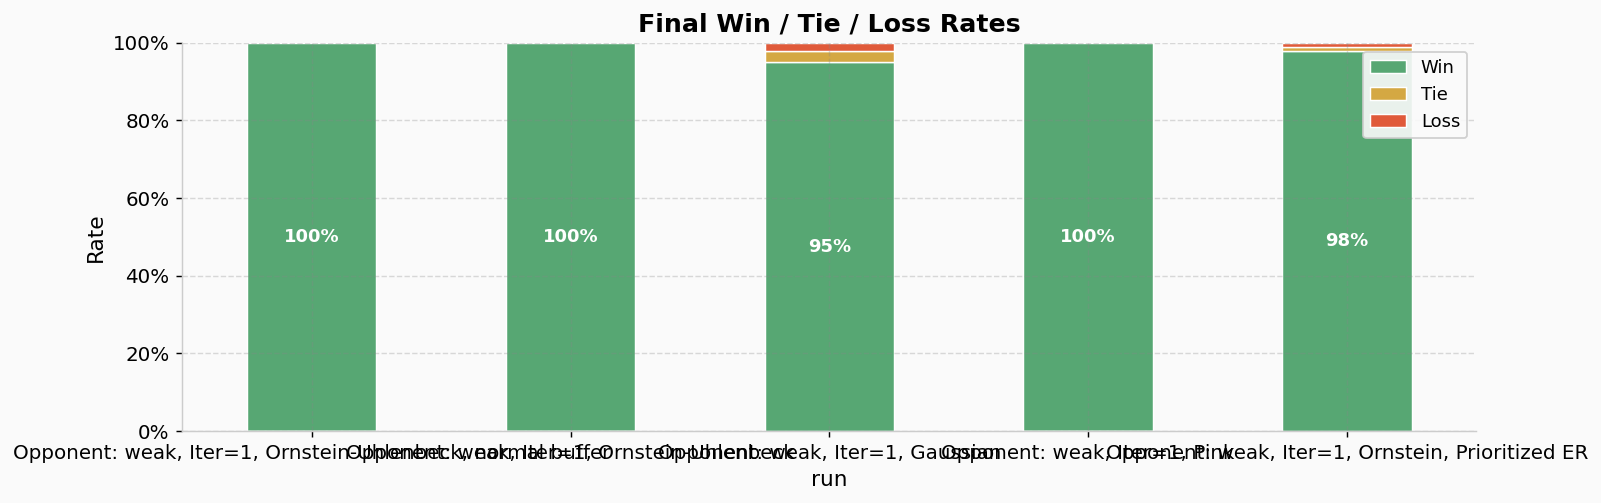

In [251]:
# Compute final rates (last SMOOTHING_WINDOW episodes)
summary = []
for name, df in runs.items():
    tail = df.tail(SMOOTHING_WINDOW)
    summary.append({
        'run': name,
        'Win':  tail['win'].mean(),
        'Tie':  tail['tie'].mean(),
        'Loss': tail['loss'].mean(),
    })
summary_df = pd.DataFrame(summary).set_index('run')

fig, ax = plt.subplots(figsize=(max(4, 2.5 * len(runs)), 4))
bar_colors = ['#57A773', '#D4A843', '#E05A3A']
summary_df.plot.bar(stacked=True, color=bar_colors, edgecolor='white',
                    linewidth=0.8, ax=ax, width=0.5)
ax.set_ylabel('Rate')
ax.set_title('Final Win / Tie / Loss Rates')
ax.set_ylim(0, 1)
ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1.0))
ax.legend(loc='upper right')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

# Annotate percentages
for i, (_, row) in enumerate(summary_df.iterrows()):
    cumulative = 0
    for col, color in zip(['Win', 'Tie', 'Loss'], bar_colors):
        val = row[col]
        if val > 0.03:  # only label if big enough to read
            ax.text(i, cumulative + val / 2, f'{val:.0%}',
                    ha='center', va='center', fontsize=10, fontweight='bold',
                    color='white')
        cumulative += val

plt.tight_layout()
plt.show()

# State visitation

In [252]:
import hockey.hockey_env as hockey_env
from TD3_agent import TD3_Agent
from gymnasium import spaces

env = hockey_env.HockeyEnv()
full_action_space = env.action_space
n_actions_per_player = full_action_space.shape[0] // 2
agent_action_space = spaces.Box(low=full_action_space.low[:n_actions_per_player],
                                high=full_action_space.high[:n_actions_per_player],
                                dtype=full_action_space.dtype)
device = "cpu"
TD3 = TD3_Agent(
    obs_dim = env.observation_space.shape[0],
    act_dim = n_actions_per_player,
    observation_space = env.observation_space,
    action_space = agent_action_space, 
    device = device,
)
TD3.load('./1985808/saved/td3_final.pt')
# collect states from a rollout
states = []
state, _ = env.reset()
for _ in range(10000):
    action = TD3.select_action(state, explore=True)
    state, _, terminated, truncated, _ = env.step(action)
    states.append(state)
    if terminated or truncated:
        state, _ = env.reset()

states = np.array(states)

# PCA projection
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
proj = pca.fit_transform(states)

plt.scatter(proj[:, 0], proj[:, 1], alpha=0.1, s=1)
plt.title(f"State coverage (PCA) — explained variance: {pca.explained_variance_ratio_.sum():.1%}")

Loaded saved from ./1985808/saved/td3_final.pt


TypeError: Expected tuple or list of length 2, got length 0